In [0]:
from keras.layers import *
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from google.colab import files


def squash(X, axis=1):
    norm = K.sum(K.square(X), axis=1, keepdims=True)
    X = K.sqrt(norm) / (1 + norm) * X

    return X

class CapsuleLayer(Layer):
    def __init__(self,
                 units,
                 n_capsules,
                 routing_iterations=5,
                 kernel_initializer='glorot_uniform',
                 **kwargs):

        """

        :param units: int. The number of neurons to use in the weight matrix for each capsule
        :param n_capsules: int. The number of capsules to use in the layer
        :param routing_iterations: int. Number of iterations for the dynamic routing algorithm
        """

        self.units = units
        self.n_capsules = n_capsules
        self.routing_iterations = routing_iterations
        self.kernel_initialzer = initializers.get(kernel_initializer)

        super().__init__(**kwargs)


    def build(self, input_shape):
        """
        :param input_shape: tuple. (batch size, n_capsules in last layer, output vector dimension)
        :return:
        """

        batch_size = input_shape[0]
        self.n_capsules_prev = input_shape[1]
        self.input_dim = input_shape[2]

        # the total number of weights is n_capsule_last_layer * n_capsules, separated into differnt axis
        # the size of the weights is output_dim * input_dim
        self.W = self.add_weight(name='capsule_weights',
                                 shape=(self.units, self.input_dim, self.n_capsules_prev, self.n_capsules),
                                 initializer=self.kernel_initialzer,
                                 trainable=True)

        self.built = True

    def call(self, inputs, **kwargs):

        # change to something more generalizable if available
        # ijkl, jk -> ikl means contract on j and keep k
        # the output shape of this tensor should be (None, output_dim, n_capsules_prev, n_capsules)
        u_ji = tf.einsum('ijkl,bkj->bikl', self.W, inputs)

        # initialize the prior probablilities of capsule i linking with capsule j to be all zeros
        # this is of shape (None, n_capsules_prev, n_capsules)
        b_ij = tf.zeros(shape=(K.shape(u_ji)[0], self.n_capsules_prev, self.n_capsules), dtype='float32')

        for r in range(self.routing_iterations):
            # coupling coefficient
            C = K.softmax(b_ij)

            # now for the total input, this has shape (None, output_dim, n_capsules)
            s_j = tf.einsum('bijk,bjk->bik', u_ji, C)

            # apply the squashing function
            v_j = squash(s_j)
            
            if r < self.routing_iterations-1:
                # update B, the output here should be of shape (None, n_capsules, n_capsules_prev)
                similarity_uv = tf.einsum('bijk,bik->bjk', u_ji, v_j)

                b_ij = b_ij + similarity_uv

        return v_j

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return (batch_size, self.units, self.n_capsules)
    
class MaskCapsules(Layer):
    """
    Mask out capsules preset label before reconstruction
    """
    def __init__(self, **kwargs):
        self.built = True
        super().__init__(**kwargs)
    
    def call(self, inputs, **kwargs):
        assert len(inputs) == 2, "Provide a mask"
        
        X, mask = inputs
        
        mask = K.one_hot(mask, num_classes=X.shape[-1])
      
        masked = K.sum(X * mask, axis=-1)
        
        return masked
    
    def compute_output_shape(self, input_shape):
        input_shape = input_shape[0]
        return (input_shape[0], input_shape[1])
        

def primary_capsules(inputs,
                     n_capsules,
                     channels=32,
                     kernel_size=9,
                     strides=2,
                     padding='valid'):
    """
    Primary caps layer

    :param n_capsules:
    :param channels:
    :param kernel_size:
    :param strides:
    :param padding:
    :return:
    """

    capsules = []

    loop_count = min([n_capsules, channels])
    channels = max([n_capsules, channels])

    for i in range(loop_count):
        conv = Conv2D(filters=channels,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding=padding,
                      name='primarycaps_conv2d_{}'.format(i))(inputs)

        capsules.append(conv)

    concat_output = Concatenate(axis=-1)(capsules)

    return concat_output

def l2_norm(X, axis=1):
    """
    Calculates the l2 norm of a tensor across an axis
    :param X: Tensor
    :param axis: the axis to sum across
    :return:
    """

    norm = K.sqrt(K.sum(K.square(X), axis=axis))
    return norm

def digits_loss(y_true, y_pred):
    """
    implement the digit loss in Hinton's paper
    :param y_true: array. (batch_size, n_classes)
    :param y_pred: array. (batch_size, n_classes)
    :return:
    """

    # level of confidence for each case when T_k == 1/0
    m_plus = .9
    m_minus = .1

    # down-weighting to stop the vector norms to be all shrunk initially
    l = .5

    positivity = K.maximum(0., m_plus - y_pred)
    negativity = K.maximum(0., y_pred - m_minus)

    L = K.mean(K.sum(y_true * positivity + l * (1 - y_true) * negativity, axis=1))

    return L

In [0]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 9, activation='relu', input_shape=(28, 28, 1))(inputs)
x = primary_capsules(x, 8, 32, 9, 2)
x = Reshape((-1, 8))(x)
x = Lambda(squash)(x)
caps_output = CapsuleLayer(16, 10)(x)
x = Lambda(l2_norm)(caps_output)

y = Input(shape=(1, ), dtype='int32')
masked = MaskCapsules()([caps_output, y])
r = Dense(512, activation='relu', name='decoder_1')(masked)
r = Dense(1028, activation='relu', name='decoder_2')(r)
r = Dense(784, activation='relu', name='decoder_3')(r)

train_model = Model(inputs=[inputs, y], outputs=[x, r, masked])
test_model = Model(inputs=[inputs], outputs=x)

train_model.compile(loss=[digits_loss, 'mse', None], loss_weights=[1, .05, 0], metrics=['accuracy'], optimizer='adam')

In [3]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 32)   2624        input_1[0][0]                    
__________________________________________________________________________________________________
primarycaps_conv2d_0 (Conv2D)   (None, 6, 6, 32)     82976       conv2d_1[0][0]                   
__________________________________________________________________________________________________
primarycaps_conv2d_1 (Conv2D)   (None, 6, 6, 32)     82976       conv2d_1[0][0]                   
__________________________________________________________________________________________________
primarycap

In [4]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train/255, X_test/255

X_train_r = X_train.reshape(-1, 784)

y_train_oh = to_categorical(y_train)

hist = train_model.fit([X_train[..., np.newaxis], y_train], 
                        [y_train_oh, X_train_r],
                        batch_size=512, 
                        validation_split=.2, 
                        epochs=5)

11493376/11490434 [==============================] - 0s 0us/step
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 80s 2ms/step - loss: 0.5992 - lambda_4_loss: 0.5954 - decoder_3_loss: 0.0761 - lambda_4_acc: 0.6936 - decoder_3_acc: 0.0086 - val_loss: 0.2736 - val_lambda_4_loss: 0.2706 - val_decoder_3_loss: 0.0583 - val_lambda_4_acc: 0.9395 - val_decoder_3_acc: 0.0073
Epoch 2/5
48000/48000 [==============================] - 77s 2ms/step - loss: 0.1452 - lambda_4_loss: 0.1423 - decoder_3_loss: 0.0578 - lambda_4_acc: 0.9549 - decoder_3_acc: 0.0072 - val_loss: 0.0642 - val_lambda_4_loss: 0.0614 - val_decoder_3_loss: 0.0564 - val_lambda_4_acc: 0.9698 - val_decoder_3_acc: 0.0053
Epoch 3/5
48000/48000 [==============================] - 77s 2ms/step - loss: 0.0519 - lambda_4_loss: 0.0490 - decoder_3_loss: 0.0576 - lambda_4_acc: 0.9756 - decoder_3_acc: 0.0078 - val_loss: 0.0426 - val_lambda_4_loss: 0.0397 - val_decoder_3_loss: 0.0564 - va

In [0]:
_, img, latent = train_model.predict([X_train[..., np.newaxis], y_train])
pred = test_model.predict(X_test[..., np.newaxis])

In [5]:
# accuracy score on the test set
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, pred.argmax(axis=-1)))

0.9902


In [0]:
train_model.save_weights('CapsNet.h5')
files.download('CapsNet.h5')

In [0]:
# Check out the activations of filters in the primary capsules
imgs = []

for i in range(32):
    output = K.mean(train_model.layers[2].output[..., i])

    grad = K.gradients(output, train_model.input)[0]
    grad /= (K.sqrt(K.mean(K.square(grad))) + 1e-5)

    e = K.function([train_model.input[0]], [grad])

#     x = np.zeros((1, 28, 28, 1))

    x = X_test[0:1, :, :, np.newaxis]

    for i in range(60):
        g = e([x])[0]

        x = x + .1*g
        
    imgs.append(x)

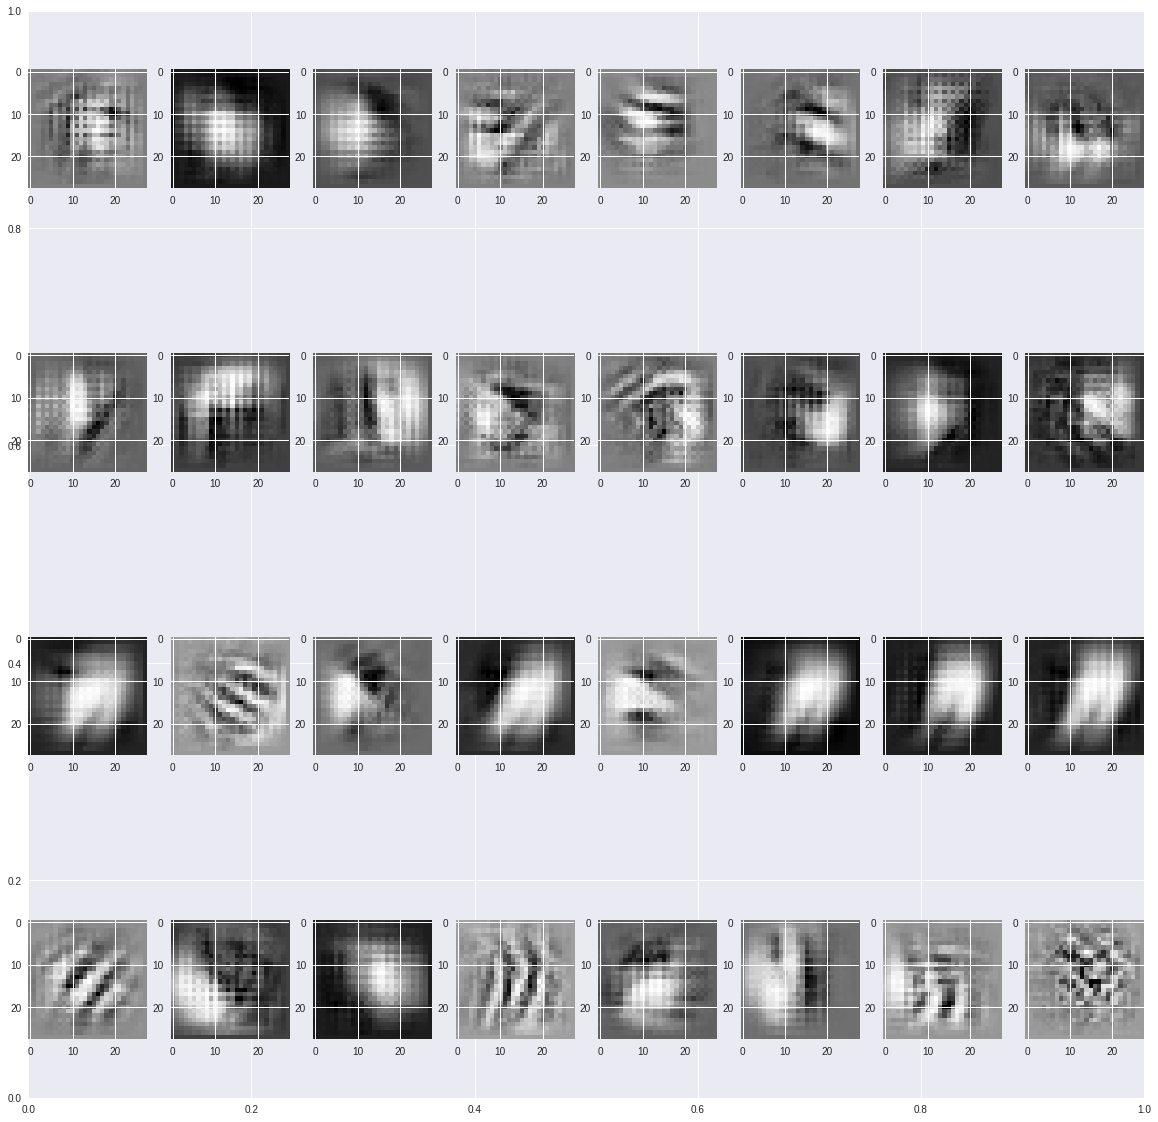

In [8]:
fig, _ = plt.subplots(figsize=(20, 20))

for i, img in enumerate(imgs):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(img[0, :, :, 0])

In [0]:
# Visualizing the vector representations

from sklearn.manifold import TSNE

tsne = TSNE(2, verbose=1)
latent = tsne.fit_transform(latent)

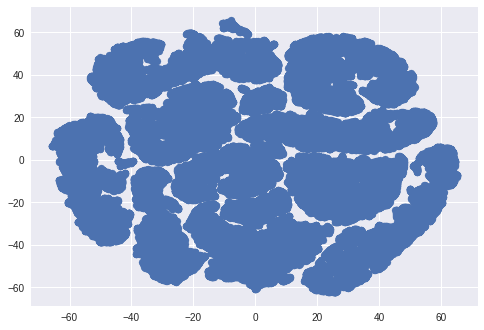

In [15]:
plt.scatter(latent[:, 0], latent[:, 1])

In [0]:
# visualizing the decoder's output

decoder = Sequential()
decoder.add(Dense(512, input_shape=(16, ), activation='relu'))
decoder.add(Dense(1028, activation='relu'))
decoder.add(Dense(784, activation='relu'))

for i, layer in enumerate(decoder.layers):
    layer.set_weights(train_model.get_layer('decoder_{}'.format(i+1)).get_weights())

In [0]:
# function for ease of varying the values along a dimension in a batch of vectors
def vary_dimension(n, dim=1, variable_dim=0, start=0, end=1, **kwargs):
    """
    Vary a sample of vectors along a certain dimension
    """
    input_vec = kwargs.get('input_vec')
    
    step = (end - start) / n
    
    varied_dimension = np.arange(start, end, step).reshape((n, ))
    
    if input_vec is not None:
        whole = np.tile(input_vec, (n, 1))
    else:
        whole = np.tile(np.random.uniform(start, end, size=(1, dim)), (n, 1))
    
    whole[:, variable_dim] = varied_dimension
    
    return whole

In [0]:
# input_latent = np.random.normal(size=(20, 16))
input_latent = vary_dimension(20, dim=16, variable_dim=2, start=-.25, end=.25, input_vec=centroids[4, :])
decoder_img = decoder.predict(input_latent)

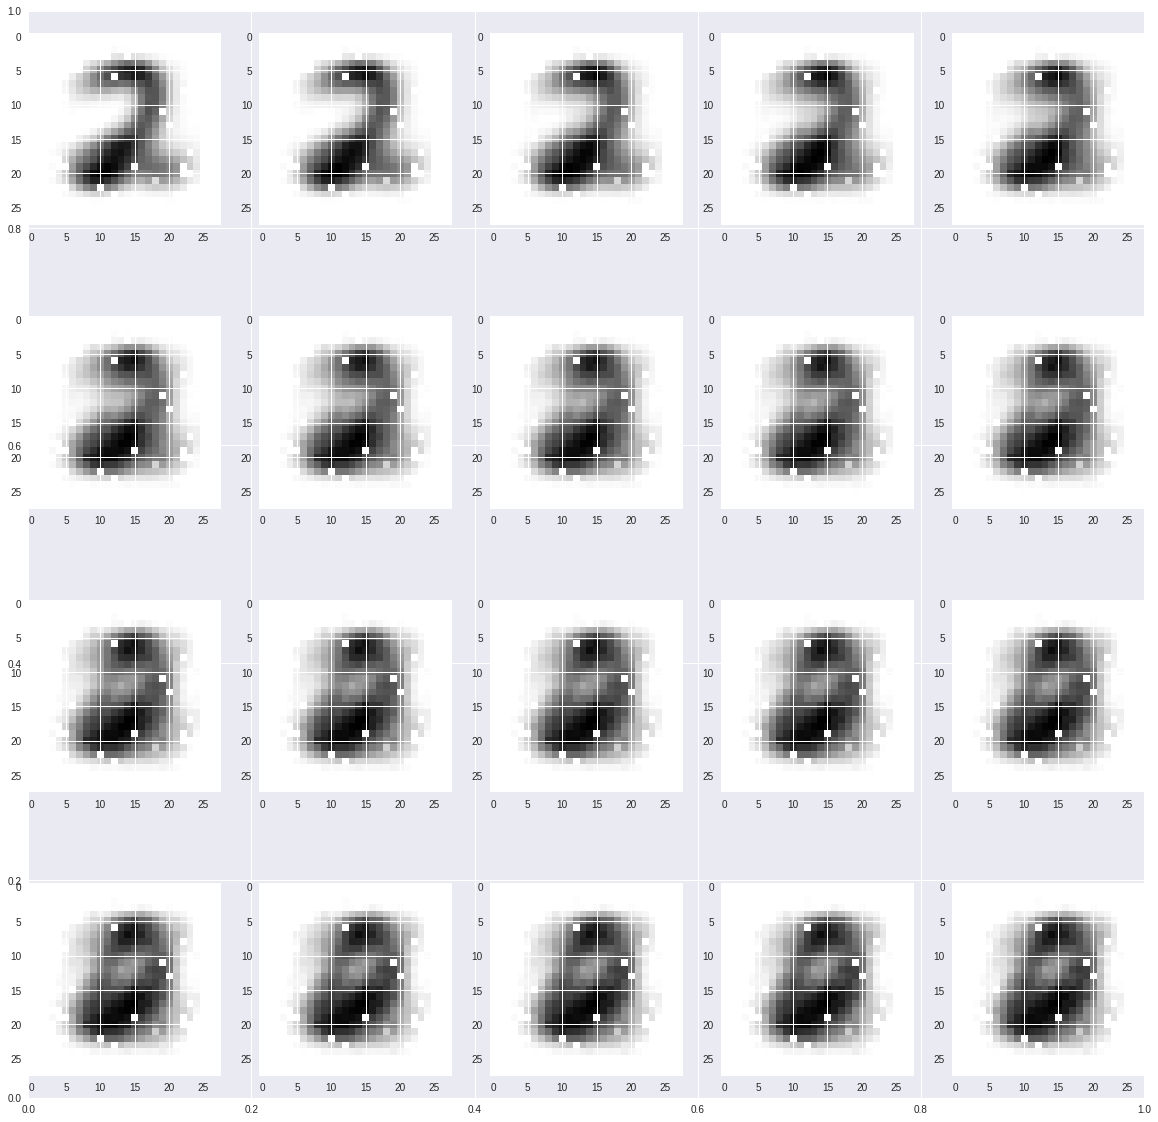

In [23]:
fig, _ = plt.subplots(figsize=(20, 20))

for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(decoder_img[i].reshape(28,28))

# Try out CIFAR-10

In [0]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train/255, X_test/255

In [31]:
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, 9, activation='relu', kernel_initializer='glorot_uniform')(inputs)
x = primary_capsules(x, 64, 32, 9, 2)
x = Reshape((-1, 64))(x)
x = Lambda(squash)(x)
caps_output = CapsuleLayer(16, 10, kernel_initializer='glorot_normal')(x)
x = Lambda(l2_norm)(caps_output)

# z = Input(shape=(1, ), dtype='int32')
# masked = MaskCapsules()([caps_output, z])
# r = Reshape((4, 4, 1))(masked)
# r = UpSampling2D(size=(2, 2), data_format='channels_last', )(r)
# r = Conv2D(4, 4, activation='relu', padding='same')(r)
# r = UpSampling2D(size=(2, 2), data_format='channels_last')(r)
# r = Conv2D(4, 4, activation='relu', padding='same')(r)
# r = UpSampling2D(size=(2, 2), data_format='channels_last')(r)
# r = Conv2D(3, 16, activation='relu', padding='same')(r)

cifar_model = Model(inputs=[inputs], outputs=[x])
cifar_model.compile(loss=[digits_loss], loss_weights=[1], optimizer='adam', metrics=['accuracy'])
cifar_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 24, 24, 32)   7808        input_13[0][0]                   
__________________________________________________________________________________________________
primarycaps_conv2d_0 (Conv2D)   (None, 8, 8, 64)     165952      conv2d_14[0][0]                  
__________________________________________________________________________________________________
primarycaps_conv2d_1 (Conv2D)   (None, 8, 8, 64)     165952      conv2d_14[0][0]                  
__________________________________________________________________________________________________
primarycap

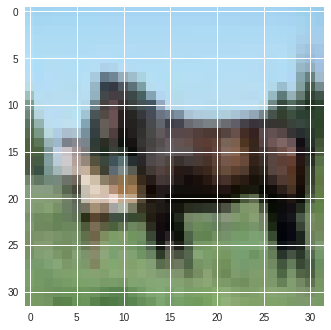

In [18]:
plt.imshow(X_train[12])

In [39]:
y_train_oh = to_categorical(y_train)

hist = cifar_model.fit([X_train], [y_train_oh], validation_split=.15, batch_size=256, epochs=15)

Train on 42500 samples, validate on 7500 samples
Epoch 1/15
42500/42500 [==============================] - 218s 5ms/step - loss: 0.7619 - acc: 0.3815 - val_loss: 0.7497 - val_acc: 0.3904
Epoch 2/15
42500/42500 [==============================] - 218s 5ms/step - loss: 0.7312 - acc: 0.4157 - val_loss: 0.7977 - val_acc: 0.3451
Epoch 3/15
42500/42500 [==============================] - 219s 5ms/step - loss: 0.7068 - acc: 0.4376 - val_loss: 0.7434 - val_acc: 0.3992
Epoch 4/15
42500/42500 [==============================] - 219s 5ms/step - loss: 0.6778 - acc: 0.4676 - val_loss: 0.6892 - val_acc: 0.4512
Epoch 5/15
42500/42500 [==============================] - 219s 5ms/step - loss: 0.6603 - acc: 0.4836 - val_loss: 0.7232 - val_acc: 0.4125
Epoch 6/15
42500/42500 [==============================] - 219s 5ms/step - loss: 0.6600 - acc: 0.4826 - val_loss: 0.6987 - val_acc: 0.4443
Epoch 7/15
42500/42500 [==============================] - 218s 5ms/step - loss: 0.6350 - acc: 0.5043 - val_loss: 0.7030 - v

In [40]:
pred =cifar_model.predict([X_test], verbose=1, batch_size=256)

10000/10000 [==============================] - 15s 1ms/step


In [41]:
# accuracy score on the test set
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, pred.argmax(axis=-1)))

0.3954


The accuracy on CIFAR-10 is significantly worse than MNIST. But this problem seems to be common among other implementation of CapsNet. It worth noting that Hinton et al got their results by averaging across 7 different trained CapsNet.

Further enhancement of CapsNet is provided in this paper, leave this for future work 

https://openreview.net/pdf?id=HJWLfGWRb